In [1]:
%matplotlib inline
!pip install tensorboardcolab

import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorboardcolab

Using TensorFlow backend.


In [2]:
# load cifar10 dataset 
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
# reshape (None, 1) -> (None)
y_train, y_test = [np.reshape(y_train, [-1]), np.reshape(y_test, [-1])]

# normalization 
x_train, x_test = [(x_train - x_train.max()) / (x_train.max() - x_train.min()),
                   (x_test - x_test.max()) / (x_test.max() - x_test.min())]

# N class
n_classes = 10
print('image shape : {}, label shape : {} '.format(x_train.shape, y_train.shape))
print('image shape : {}, label shape : {} '.format(x_test.shape, y_test.shape))
print('train minimun : {}, train_maximum : {} '.format(x_train.min(), x_train.max()))
print('tests minimun : {}, test_maximum : {} '.format(x_test.min(), x_test.max()))

image shape : (50000, 32, 32, 3), label shape : (50000,) 
image shape : (10000, 32, 32, 3), label shape : (10000,) 
train minimun : 0.0, train_maximum : 1.0 
tests minimun : 0.0, test_maximum : 1.0 


In [4]:
temp = x_train
ratio = int(len(x_train) * 0.7)
ratio_end = int(len(x_train) * 1.0)

x_train = temp[0:ratio, :, :, :]
x_validation = temp[ratio:ratio_end , :, :, :]

y_train_label = y_train[0:ratio]
y_validation_label = y_train[ratio:ratio_end ]

print(y_train_label[:10]) # label이 one_hot encoding상태가 아니다.

print(x_train.shape, y_train_label.shape)
print(x_validation.shape, y_validation_label.shape)

[6 9 9 4 1 1 2 7 8 3]
(35000, 32, 32, 3) (35000,)
(15000, 32, 32, 3) (15000,)


## Data Provider

In [0]:
class DataProvider(object):
    def __init__(self, x, y):
        self.epoch_count = 0
        
        self.data = x
        self.label = y
        
        npr.seed(42)
        
        self.indices = self.generate_indices()
        
    def generate_indices(self):
        indices = list(range(len(self.data)))
        npr.shuffle(indices)
        
        return indices
    
    def next_batch(self, batch_size):
        idx = batch_size
        if len(self.indices) < batch_size:
            print("all data consumed, epoch + 1")
            self.epoch_count += 1
            self.indices = self.generate_indices()
    
        target_indices = self.indices[:batch_size]
        del self.indices[:batch_size]
        
        return self.data[target_indices] , self.label[target_indices]

In [0]:
def cifar_generator(data, labels, batch_size=32):
    start_idx = 0
    num_step = len(data) // batch_size
    indexes = np.arange(0, len(data))
    while True:
        if start_idx >= num_step-1:
            np.random.shuffle(indexes)
            start_idx = 0
        else:
            start_idx += 1            
        batch_index = indexes[start_idx*batch_size:
                              (start_idx+1)*batch_size]

        batch_data = data[batch_index]
        batch_label = labels[batch_index]

        yield batch_data, batch_label

## Model A : Build

In [7]:
graph = tf.Graph()
with graph.as_default() :
    xs = tf.placeholder(tf.float32, (None, 32, 32, 3), name='xs') # 32*32 = 1024
    ys = tf.placeholder(tf.int32, (None), name='ys')
    lr = tf.placeholder_with_default(0.001, (), name='lr')
    wd = tf.placeholder_with_default(0.9, (), name='wd')
    is_train = tf.placeholder_with_default(False, (), name='is_train')
    
    with tf.name_scope('conv1') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[3, 3, 3, 32], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') 
        bias_init   = tf.zeros([32])
        kernel      = tf.Variable(kernel_init, name='kernel1')               
        bias        = tf.Variable(bias_init, name='bias1')
    
        layer       = tf.nn.conv2d(xs, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer       = layer + bias
        layer       = tf.nn.relu(layer)
        
        kernel_init = tf.random.normal(shape=[3, 3, 32, 32], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') 
        bias_init   = tf.zeros([32])
        kernel      = tf.Variable(kernel_init, name='kernel2')     
        bias        = tf.Variable(bias_init, name='bias2')
    
        layer       = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding='SAME') 
        layer       = layer + bias
        layer       = tf.nn.relu(layer)
          
            
    with tf.name_scope('conv2') :   ## filters is number of channels
        kernel_init = tf.random.normal(shape=[3, 3, 32, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init') 
        bias_init   = tf.zeros([64])
        kernel      = tf.Variable(kernel_init, name='kernel1')    
        bias        = tf.Variable(bias_init, name='bias1')    
        layer       = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding='SAME') # convolution and add bias   
        layer       = layer + bias
        layer       = tf.nn.relu(layer)

        kernel_init = tf.random.normal(shape=[3, 3, 64, 64], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init')             
        bias_init   = tf.zeros([64])
        kernel      = tf.Variable(kernel_init, name='kernel2')   
        bias        = tf.Variable(bias_init, name='bias2')    
        layer       = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding='SAME')    
        layer       = layer + bias
        layer       = tf.nn.relu(layer)
    
        pool        = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)        

    with tf.name_scope('conv3') :   ## filters is number of channels        
        kernel_init = tf.random.normal(shape=[3, 3, 64, 128], mean=0.0, stddev=0.1, dtype=tf.float32, name='kernel_init')     
        bias_init   = tf.zeros([128])
        kernel      = tf.Variable(kernel_init, name='kernel2')           
        bias        = tf.Variable(bias_init, name='bias2')    
        layer       = tf.nn.conv2d(pool, kernel, strides=[1,3,3,1], padding='SAME')  
        layer       = layer + bias
        layer       = tf.nn.relu(layer)
    
        pool        = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)      
    # receptive filed = 20, images size = 32, output imagesize = (3, 3)

    # Layer #	Kernel Stride	Dilation	Padding	Input Size	Output Size	Receptive Field
    #    1	      3	       1	   1	       2	      32    	 32	          3
    #    2	      3	       1	   1	       2	      32    	 32	          5
    #    3	      3	       1	   1	       2	      32    	 32	          7
    #    4	      3	       1	   1	       2	      32    	 32	          9
    #    5	      2	       2	   1	       0	      32    	 16	          10
    #    6	      3	       3	   1	       1	      16    	 6	          14
    #    7	      2	       2	   1	       0	      6	         3 	          20
    with tf.name_scope('Reconstruct') : 
        flatten       = tf.layers.flatten(pool)
        in_           = flatten.shape[1]  # flatten shape : (None, 4096)
        
        he_init       = tf.sqrt(2 / 1024)
        kernel_init   = tf.random.normal(shape = [1152, 1024], mean=0.0, stddev=he_init, dtype = tf.float32)
        fc1_weights1  = tf.Variable(kernel_init, name = "fc1_weights1")
        fc1_bias1     = tf.Variable(tf.zeros(shape = [1024], dtype = tf.float32), name = "fc1_bias1")
        fc1_logits    = tf.matmul(flatten, fc1_weights1) + fc1_bias1
        fc1_act       = tf.nn.relu(fc1_logits)
        fc1_dropout   = tf.layers.Dropout(0.5)(fc1_act, training = is_train)
        fc1_result    = tf.identity(fc1_dropout, "fc1_result")
        
        he_init       = tf.sqrt(2 / 1024)
        kernel_init   = tf.random.normal(shape = [1024, 1024], mean=0.0, stddev=he_init, dtype = tf.float32)
        fc2_weights1  = tf.Variable(kernel_init, name = "fc2_weights1")
        fc2_bias1     = tf.Variable(tf.zeros(shape = [1024], dtype = tf.float32), name = "fc2_bias1")
        fc2_logits    = tf.matmul(fc1_result, fc2_weights1) + fc2_bias1
        fc2_act       = tf.nn.relu(fc2_logits)
        fc2_dropout   = tf.layers.Dropout(0.5)(fc2_act, training = is_train)
        fc2_result    = tf.identity(fc2_dropout, "fc2_result")
        
        y_pred        = tf.layers.Dense(10, activation=None, name='y_pred')(fc2_result) 
        
    with tf.name_scope('Loss') :
        sce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=ys, logits=y_pred))
        l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.global_variables()])
        loss = sce_loss + wd * l2_loss
    loss = tf.identity(loss, name='loss')
        
    with tf.name_scope('metric') :
        rmse = tf.sqrt(loss)
    
    with tf.name_scope('accuracy') :
        pred = tf.cast(tf.arg_max(y_pred, 1), tf.int32)
        correct = tf.equal(pred, ys)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        # add tensor to tensorboard
        acc_tb = tf.summary.scalar(name='accuracy', tensor=accuracy)

    with tf.name_scope('train') :
        global_step = tf.train.get_or_create_global_step()
        train_op = tf.train.AdamOptimizer(lr).minimize(loss, global_step = global_step)

W0618 01:59:17.935099 140202394343296 deprecation.py:323] From <ipython-input-7-67e77dcd3010>:69: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0618 01:59:18.251314 140202394343296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0618 01:59:18.629751 140202394343296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the

## Model A : Train

In [8]:
with graph.as_default() :
    
    # 텐서보드에 연결합니다. # sess.run보다 먼저 선언해야함. 
    log_dir = "./log/vgg_net_model_a"  
    lode_dir = None
    save_dir = "./model/vgg_net_model_a"   
    
    # tbc = tensorboardcolab.TensorBoardColab(graph_path = log_dir)
    
    train_writer = tf.summary.FileWriter(logdir = log_dir)
    train_writer.add_graph(tf.get_default_graph())
    merged_all = tf.summary.merge_all()    
    
    sess = tf.Session()
    sess.run([tf.global_variables_initializer(),
              tf.local_variables_initializer()])
    
    # Step2 : 기록
    saver = tf.train.Saver() # 다 저장하겠다.
    
    # Training
    batch_size = 1000 
    n_epoch = 30
    n_step = int(len(x_train) // batch_size)  # //은 몫이다.
    learing_rate = 0.001
    weight_decay = 0.0005
    
    # instance 생성
    train_generator = cifar_generator(x_train, y_train_label, batch_size)
    
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    cnt = 0
    minimum_loss = 9999
    log_fc2_weights1_ = []
    for i in tqdm(range(n_epoch)) :
        for step in range(n_step) :
            batch_xs, batch_ys = next(train_generator)
            _, train_loss_, train_acc_, tbs_train_ = sess.run([train_op, rmse, accuracy, merged_all], feed_dict = { xs: batch_xs, 
                                                                                              ys: batch_ys, 
                                                                                              lr: learing_rate,
                                                                                              wd : weight_decay,
                                                                                              is_train : True})
            train_writer.add_summary(tbs_train_, global_step=cnt) # 흠 되야 하는데 안된다.
            cnt += 1
            train_loss.append(train_loss_)
            train_acc.append(train_acc_)
            
            # check validation set
            if step % 100 == 0 :
                loss_, acc_, fc2_weights1_ = sess.run([rmse, accuracy, fc2_weights1], feed_dict = { xs: x_validation, 
                                                                                                     ys: y_validation_label,
                                                                                                     wd : weight_decay,
                                                                                                     is_train : False})
                valid_loss.append(loss_)
                valid_acc.append(acc_)
                
                # Save the model
                if loss_ < minimum_loss :
                    print("log current model! valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
                    minimum_loss = loss_
                    saver.save(sess, save_path = save_dir)
                    log_fc2_weights1_ = fc2_weights1_
        print(" valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
    print(" valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
    print("weight가 맞는지 확인하자 -> ", log_fc2_weights1_)
    train_writer.flush() # file을 disk에 쓴다

  0%|          | 0/30 [00:00<?, ?it/s]

log current model! loss = 2.2558, acc = 10.18%


  3%|▎         | 1/30 [00:17<08:17, 17.15s/it]

loss = 2.2558, acc = 10.18%
log current model! loss = 1.7494, acc = 33.58%


  7%|▋         | 2/30 [00:24<06:34, 14.09s/it]

loss = 1.7494, acc = 33.58%
log current model! loss = 1.5953, acc = 43.80%


 10%|█         | 3/30 [00:31<05:22, 11.96s/it]

loss = 1.5953, acc = 43.80%
log current model! loss = 1.5174, acc = 48.79%


 13%|█▎        | 4/30 [00:38<04:32, 10.46s/it]

loss = 1.5174, acc = 48.79%
log current model! loss = 1.4676, acc = 51.52%


 17%|█▋        | 5/30 [00:45<03:55,  9.43s/it]

loss = 1.4676, acc = 51.52%
log current model! loss = 1.4437, acc = 52.32%


 20%|██        | 6/30 [00:52<03:29,  8.71s/it]

loss = 1.4437, acc = 52.32%
log current model! loss = 1.3718, acc = 57.95%


 23%|██▎       | 7/30 [00:59<03:09,  8.22s/it]

loss = 1.3718, acc = 57.95%
log current model! loss = 1.3380, acc = 59.57%


 27%|██▋       | 8/30 [01:06<02:53,  7.88s/it]

loss = 1.3380, acc = 59.57%
log current model! loss = 1.3236, acc = 60.21%


 30%|███       | 9/30 [01:13<02:40,  7.65s/it]

loss = 1.3236, acc = 60.21%
log current model! loss = 1.2864, acc = 62.72%


 33%|███▎      | 10/30 [01:20<02:29,  7.50s/it]

loss = 1.2864, acc = 62.72%
log current model! loss = 1.2725, acc = 64.02%


 37%|███▋      | 11/30 [01:27<02:20,  7.40s/it]

loss = 1.2725, acc = 64.02%
log current model! loss = 1.2480, acc = 65.18%


 40%|████      | 12/30 [01:34<02:12,  7.35s/it]

loss = 1.2480, acc = 65.18%
log current model! loss = 1.2280, acc = 66.08%


 43%|████▎     | 13/30 [01:42<02:04,  7.32s/it]

loss = 1.2280, acc = 66.08%
log current model! loss = 1.2274, acc = 66.01%


 47%|████▋     | 14/30 [01:49<01:56,  7.31s/it]

loss = 1.2274, acc = 66.01%
log current model! loss = 1.2173, acc = 66.52%


 50%|█████     | 15/30 [01:56<01:49,  7.30s/it]

loss = 1.2173, acc = 66.52%


 53%|█████▎    | 16/30 [02:04<01:42,  7.29s/it]

loss = 1.2242, acc = 66.23%
log current model! loss = 1.2050, acc = 67.39%


 57%|█████▋    | 17/30 [02:11<01:35,  7.32s/it]

loss = 1.2050, acc = 67.39%


 60%|██████    | 18/30 [02:18<01:27,  7.33s/it]

loss = 1.2123, acc = 67.34%
log current model! loss = 1.2022, acc = 68.10%


 63%|██████▎   | 19/30 [02:26<01:21,  7.37s/it]

loss = 1.2022, acc = 68.10%
log current model! loss = 1.1987, acc = 68.36%


 67%|██████▋   | 20/30 [02:33<01:13,  7.38s/it]

loss = 1.1987, acc = 68.36%


 70%|███████   | 21/30 [02:40<01:06,  7.36s/it]

loss = 1.1991, acc = 68.85%


 73%|███████▎  | 22/30 [02:48<00:58,  7.35s/it]

loss = 1.2053, acc = 68.47%
log current model! loss = 1.1984, acc = 68.54%


 77%|███████▋  | 23/30 [02:55<00:51,  7.37s/it]

loss = 1.1984, acc = 68.54%


 80%|████████  | 24/30 [03:03<00:44,  7.36s/it]

loss = 1.2136, acc = 68.71%


 83%|████████▎ | 25/30 [03:10<00:36,  7.38s/it]

loss = 1.2144, acc = 68.81%


 87%|████████▋ | 26/30 [03:17<00:29,  7.40s/it]

loss = 1.2278, acc = 69.08%


 90%|█████████ | 27/30 [03:25<00:22,  7.43s/it]

loss = 1.2236, acc = 68.81%


 93%|█████████▎| 28/30 [03:32<00:14,  7.44s/it]

loss = 1.2264, acc = 69.01%


 97%|█████████▋| 29/30 [03:40<00:07,  7.44s/it]

loss = 1.2414, acc = 68.58%


100%|██████████| 30/30 [03:47<00:00,  7.45s/it]

loss = 1.2375, acc = 69.57%
loss = 1.2375, acc = 69.57%
weight가 맞는지 확인하자 ->  [[ 2.71307137e-02 -1.25479437e-02  2.35868134e-02 ...  3.18341865e-03
  -1.23903230e-02 -3.40513252e-02]
 [ 1.76205412e-02  8.06861464e-03 -1.41466055e-02 ...  2.62078624e-02
  -1.16349792e-03 -1.31203244e-02]
 [ 1.31812096e-02  1.92907900e-02 -8.44401121e-03 ... -4.72040083e-05
   3.89633328e-02  4.45121853e-03]
 ...
 [ 1.60037894e-02 -1.04974322e-02  1.55837657e-02 ...  2.07463447e-02
   2.84298230e-03  2.46870182e-02]
 [ 9.52524599e-04 -3.47122294e-03  3.87140177e-02 ...  1.65685099e-02
  -2.02795472e-02 -1.26976082e-02]
 [ 3.02585840e-06  1.30706057e-05  7.41337362e-06 ... -5.87957256e-05
   1.98324210e-06  5.80111646e-06]]


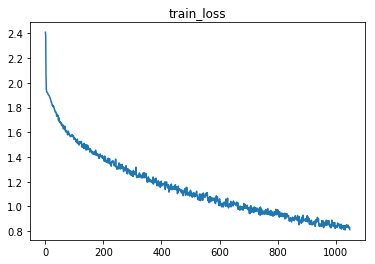

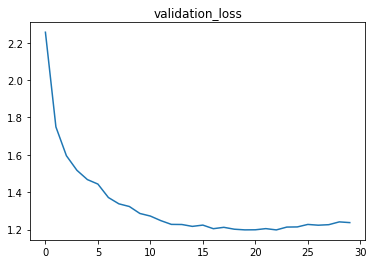

In [9]:
plt.plot(np.arange(0, len(train_loss), 1), train_loss)
plt.title("train_loss")
plt.show()

plt.plot(np.arange(0, len(valid_loss), 1), valid_loss)
plt.title("validation_loss")
plt.show() # train과 validation 모두 봐야 한다.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir gdrive/My\ Drive/vgg
!mv ./model/vgg* gdrive/My\ Drive/vgg
!mv ./model/checkpoint gdrive/My\ Drive/vgg

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
mkdir: cannot create directory ‘gdrive/My Drive/vgg’: File exists
